In [ ]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

In [ ]:
#data_dir='/content/drive/MyDrive/ColabNotebooks/cardir'
train_dir = '/content/drive/MyDrive/ColabNotebooks/lfw_Train'
valid_dir = '/content/drive/MyDrive/ColabNotebooks/lfw_Valid'
test_dir ='/content/drive/MyDrive/ColabNotebooks/lfw_Test'
test_dir_lr='/content/drive/MyDrive/ColabNotebooks/lfw_Test_lr'
test_dir_lr05='/content/drive/MyDrive/ColabNotebooks/lfw_Test_lr_0.5'
test_dir_lr1='/content/drive/MyDrive/ColabNotebooks/lfw_Test_lr_noise1'
test_dir_lr15='/content/drive/MyDrive/ColabNotebooks/lfw_Test_lr_1.5'

In [ ]:
# Training transform includes random rotation and flip to build a more robust model
train_transforms = transforms.Compose([transforms.Resize((244,244)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# The validation set will use the same transform as the test set
test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_transforms = transforms.Compose([transforms.Resize((244,244)),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms,
                                  loader=lambda x: Image.open(x).convert('RGB')
                                  )
valid_data = datasets.ImageFolder(valid_dir, transform=validation_transforms,
                                  loader=lambda x: Image.open(x).convert('RGB')
                                  )
test_data = datasets.ImageFolder(test_dir, transform=test_transforms,
                                 loader=lambda x: Image.open(x).convert('RGB')
                                 )

# Using the image datasets and the trainforms, define the dataloaders
# The trainloader will have shuffle=True so that the order of the images do not affect the model
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 239MB/s]


In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 57)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [ ]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0

    # change model to work with cuda
    model.to('cuda')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):

        # Change images and labels to work with cuda
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)

        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return valid_loss, accuracy

In [ ]:
epochs = 20
steps = 0
print_every = 40

# change to gpu mode
model.to('cuda')
model.train()
for e in range(epochs):

    running_loss = 0
    train_accuracy=0
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1

        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # zeroing parameter gradients
        optimizer.zero_grad()

        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = torch.exp(outputs)
        equality = (labels.data == ps.max(dim=1)[1])
        train_accuracy += equality.type(torch.FloatTensor).mean()
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()

            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)

            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Training Accuracy: {round(float(train_accuracy/print_every),3)}\
            Valid Loss: {round(valid_loss/len(validloader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")


            # Turning training back on
            model.train()
            lrscheduler.step(accuracy * 100)

No. epochs: 3,             Training Loss: 0.324             Training Accuracy: 0.227            Valid Loss: 1.156             Valid Accuracy: 0.73
No. epochs: 6,             Training Loss: 0.042             Training Accuracy: 0.245            Valid Loss: 0.373             Valid Accuracy: 0.905
No. epochs: 9,             Training Loss: 0.009             Training Accuracy: 0.2            Valid Loss: 0.277             Valid Accuracy: 0.926
No. epochs: 12,             Training Loss: 0.004             Training Accuracy: 0.15            Valid Loss: 0.235             Valid Accuracy: 0.933
No. epochs: 15,             Training Loss: 0.001             Training Accuracy: 0.1            Valid Loss: 0.214             Valid Accuracy: 0.94
No. epochs: 18,             Training Loss: 0.001             Training Accuracy: 0.05            Valid Loss: 0.205             Valid Accuracy: 0.941
No. epochs: 20,             Training Loss: 0.004             Training Accuracy: 0.35            Valid Loss: 0.213    

In [ ]:
print(model)

ResNetForIdentification(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [ ]:
correct = 0
total = 0
model.to('cuda')


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

Test accuracy of model: 93.671%


In [ ]:
checkpoint = {'state_dict': model.state_dict(),
              'model': model.fc,
              'class_to_idx': train_data.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs}

torch.save(checkpoint, '/content/drive/MyDrive/ColabNotebooks/capstone_resnetcheckpoint.pth')

NameError: ignored

In [ ]:
def load_checkpoint(filepath):

    checkpoint = torch.load(filepath)

    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']

    return model

In [ ]:
model = load_checkpoint('/content/drive/MyDrive/ColabNotebooks/capstone_resnetcheckpoint.pth')
# Checking model i.e. should have 196 output units in the classifier
#print(model)

In [ ]:
model = torch.nn.DataParallel(model)

In [ ]:
def process_image(image):

    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

    # Transforming image for use with network
    pil_tfd = transform(pil_im)

    # Converting to Numpy array
    array_im_tfd = np.array(pil_tfd)

    return array_im_tfd

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

In [ ]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file

    # Loading model
    loaded_model = load_checkpoint(model)
    # Moving the loaded model to the GPU
    loaded_model.cuda()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Moving the input tensor to the GPU
    img_tensor = img_tensor.cuda()
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)
    input=Variable(img_add_dim)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)

    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]

    # Converting probabilities and outputs to lists
    conf = np.array(probs_top.cpu())[0]
    predicted = np.array(predicted_top.cpu())[0]

    return conf, predicted



In [ ]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(train_dir)

print(classes, c_to_idx)

['Alejandro_Toledo', 'Alvaro_Uribe', 'Amelie_Mauresmo', 'Andre_Agassi', 'Ariel_Sharon', 'Arnold_Schwarzenegger', 'Atal_Bihari_Vajpayee', 'Bill_Clinton', 'Carlos_Menem', 'Colin_Powell', 'David_Beckham', 'Donald_Rumsfeld', 'George_Robertson', 'George_W_Bush', 'Gerhard_Schroeder', 'Gloria_Macapagal_Arroyo', 'Gray_Davis', 'Guillermo_Coria', 'Hamid_Karzai', 'Hans_Blix', 'Hugo_Chavez', 'Jack_Straw', 'Jacques_Chirac', 'Jean_Chretien', 'Jennifer_Aniston', 'Jennifer_Capriati', 'Jennifer_Lopez', 'Jeremy_Greenstock', 'John_Ashcroft', 'John_Negroponte', 'Jose_Maria_Aznar', 'Juan_Carlos_Ferrero', 'Junichiro_Koizumi', 'Kofi_Annan', 'Laura_Bush', 'Lindsay_Davenport', 'Lleyton_Hewitt', 'Luiz_Inacio_Lula_da_Silva', 'Mahmoud_Abbas', 'Megawati_Sukarnoputri', 'Naomi_Watts', 'Nestor_Kirchner', 'Pete_Sampras', 'Recep_Tayyip_Erdogan', 'Ricardo_Lagos', 'Roh_Moo-hyun', 'Rudolph_Giuliani', 'Saddam_Hussein', 'Serena_Williams', 'Silvio_Berlusconi', 'Tiger_Woods', 'Tom_Daschle', 'Tom_Ridge', 'Tony_Blair', 'Vicente

In [ ]:
def plot_solution(namedir, model):
  # Testing predict function

  # Inputs are paths to saved model and test image
  model_path = '/content/drive/MyDrive/ColabNotebooks/capstone_resnetcheckpoint.pth'
  image_path = test_dir_lr05+namedir
  personname = namedir.split('/')[1]

  conf2, predicted1 = predict(image_path, model_path, topk=5)
  # Converting classes to names
  names = []
  for i in range(5):

      names += [classes[predicted1[i]]]


  # Creating PIL image
  image = Image.open(image_path+'.jpg')


  # Plotting test image and predicted probabilites
  f, ax = plt.subplots(2,figsize = (6,10))

  ax[0].imshow(image)
  ax[0].set_title(personname)

  y_names = np.arange(len(names))
  ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
  ax[1].set_yticks(y_names)
  ax[1].set_yticklabels(names)
  ax[1].invert_yaxis()

  plt.show()

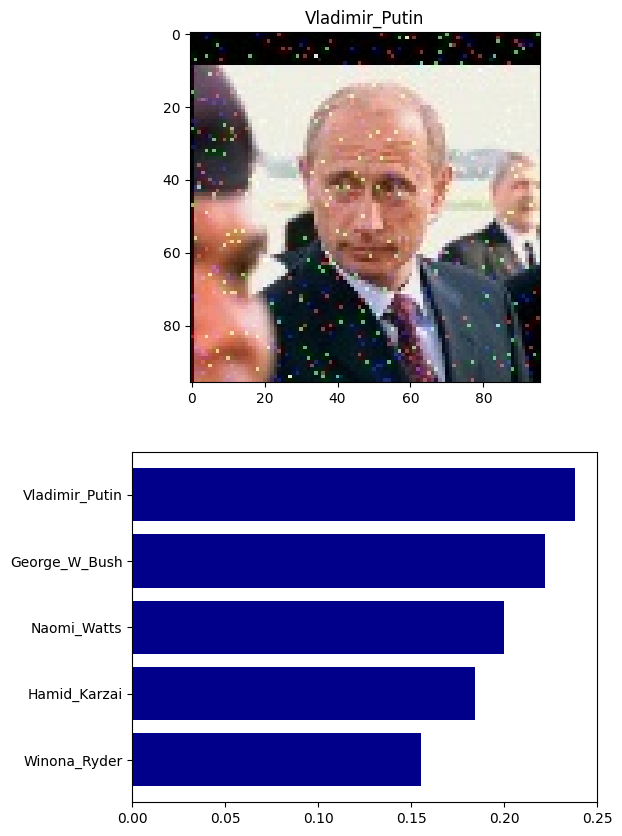

In [ ]:
namedir = '/Vladimir_Putin/Vladimir_Putin_0028'
plot_solution(namedir, model)

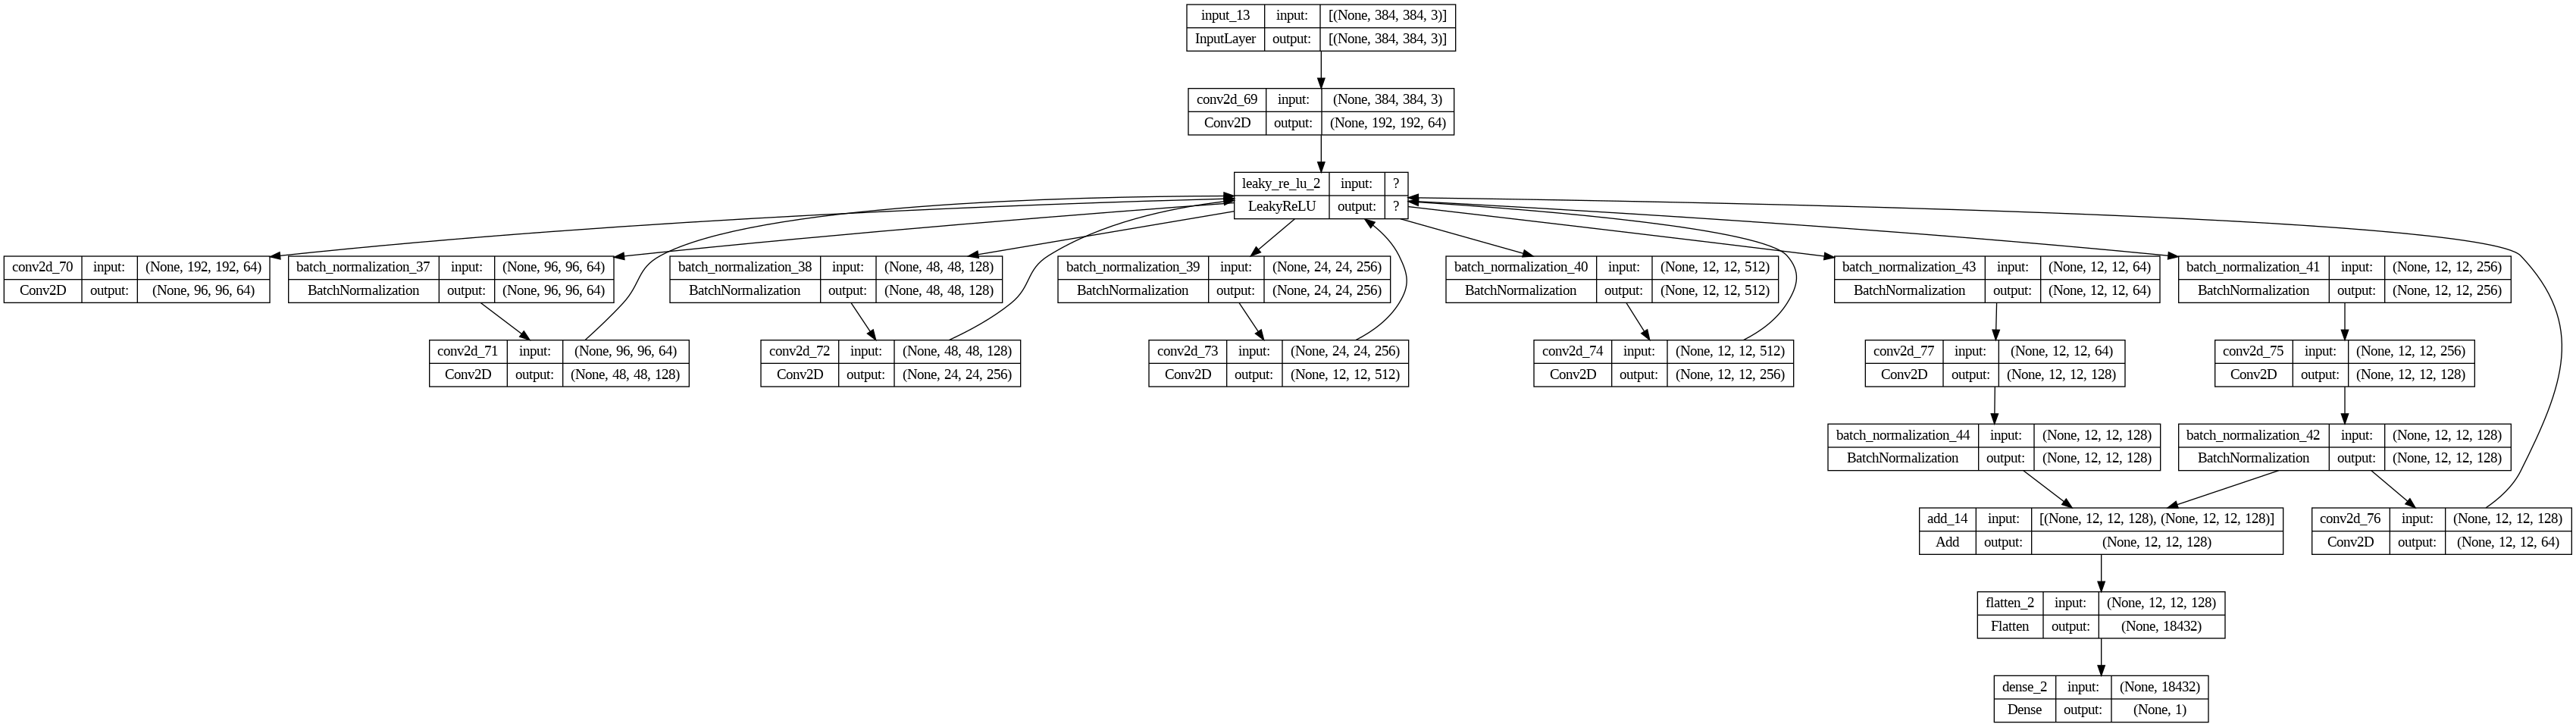

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, add, Dense, Flatten, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import plot_model
import pydot
import graphviz
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, add,\
                                    BatchNormalization, Activation, LeakyReLU, Layer

from tensorflow.keras.models import Model
from keras.models import load_model
  # Assuming you have a custom implementation of SubpixelConv2D

def get_G(input_shape):
    # w_init = tf.random_normal_initializer(stddev=0.02)
    g_init = tf.random_normal_initializer(1., 0.02)
    relu= Activation('relu')

    nin= Input(shape= input_shape)
    denoised=denoising(input_shape)(nin)
    n= Conv2D(64, (3,3), padding='SAME', activation= 'relu',
                        kernel_initializer='HeNormal')(denoised)
    temp= n


    # B residual blocks
    for i in range(3):
        nn= Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
        nn= BatchNormalization(gamma_initializer= g_init)(nn)
        nn= relu(nn)
        nn= Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
        nn= BatchNormalization(gamma_initializer= g_init)(nn)

        nn= add([n, nn])
        n= nn

    n= Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)
    n= add([n, temp])
    # B residual blacks end

    n= Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
    n= SubpixelConv2D(upsampling_factor=2)(n)
    n= relu(n)

    n= Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
    n= SubpixelConv2D(upsampling_factor=2)(n)
    n= relu(n)

    nn= Conv2D(3, (1,1), padding='SAME', kernel_initializer='HeNormal', activation= 'tanh')(n)


    G = Model(inputs=nin, outputs=nn, name="generator")
    return G
# discriminator
def get_D(input_shape):

    g_init= tf.random_normal_initializer(1., 0.02)
    ly_relu= LeakyReLU(alpha= 0.2)
    df_dim = 16

    nin = Input(input_shape)
    n = Conv2D(64, (4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(nin)
    n= ly_relu(n)

    for i in range(2, 6):
        n = Conv2D(df_dim*(2**i),(4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(n)
        n= ly_relu(n)
        n= BatchNormalization(gamma_initializer= g_init)(n)

    n= Conv2D(df_dim*16, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= ly_relu(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)

    n= Conv2D(df_dim*8, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)
    temp= n

    n= Conv2D(df_dim*4, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= ly_relu(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)

    n= Conv2D(df_dim*8, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)

    n= add([n, temp])

    n= Flatten()(n)
    no= Dense(units=1, kernel_initializer='HeNormal', activation= 'sigmoid')(n)
    D= Model(inputs=nin, outputs=no, name="discriminator")

    return D


# VGG19
def get_vgg19():
    vgg= tf.keras.applications.VGG19( include_top=False, weights='imagenet',
                                    input_tensor=None, input_shape=(256, 256, 3),
                                    pooling=None, classes=1000, classifier_activation='softmax' )

    inp= Input(shape=(384, 384, 3))
    x= vgg.layers[0](inp)
    for ly in vgg.layers[1:17]:
        x= ly(x)
    VGG19= Model(inp, x)

    return VGG19

# Create the models
generator = get_G(input_shape=(96, 96, 3))
discriminator = get_D(input_shape=(384, 384, 3))
vgg19 = get_vgg19()

# Save the architecture diagrams as PNG files
#plot_model(generator, to_file='generator_architecture.png', show_shapes=True)
plot_model(discriminator, to_file='discriminator_architecture.png', show_shapes=True)
#plot_model(vgg19, to_file='vgg19_architecture.png', show_shapes=True)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, add,\
                                    BatchNormalization, Activation, LeakyReLU, Layer
class SubpixelConv2D(Layer):
    """ Subpixel Conv2D Layer
    upsampling a layer from (h, w, c) to (h*r, w*r, c/(r*r)),
    where r is the scaling factor, default to 4
    # Arguments
    upsampling_factor: the scaling factor
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        the second and the third dimension increased by a factor of
        `upsampling_factor`; the last layer decreased by a factor of
        `upsampling_factor^2`.
    # References
        Real-Time Single Image and Video Super-Resolution Using an Efficient
        Sub-Pixel Convolutional Neural Network Shi et Al. https://arxiv.org/abs/1609.05158
    """

    def __init__(self, upsampling_factor=2, **kwargs):
        super(SubpixelConv2D, self).__init__(**kwargs)
        self.upsampling_factor = upsampling_factor

    def build(self, input_shape):
        last_dim = input_shape[-1]
        factor = self.upsampling_factor * self.upsampling_factor
        if last_dim % (factor) != 0:
            raise ValueError('Channel ' + str(last_dim) + ' should be of '
                             'integer times of upsampling_factor^2: ' +
                             str(factor) + '.')

    def call(self, inputs, **kwargs):
        return tf.nn.depth_to_space( inputs, self.upsampling_factor )

    def get_config(self):
        config = { 'upsampling_factor': self.upsampling_factor, }
        base_config = super(SubpixelConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        factor = self.upsampling_factor * self.upsampling_factor
        input_shape_1 = None
        if input_shape[1] is not None:
            input_shape_1 = input_shape[1] * self.upsampling_factor
        input_shape_2 = None
        if input_shape[2] is not None:
            input_shape_2 = input_shape[2] * self.upsampling_factor
        dims = [ input_shape[0],
                 input_shape_1,
                 input_shape_2,
                 int(input_shape[3]/factor)
               ]
        return tuple( dims )

def denoising(input_shape):
    input_img = Input(shape=input_shape)  # Input image with any size

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Create the model
    autoencoder = Model(input_img, decoded)
    return autoencoder

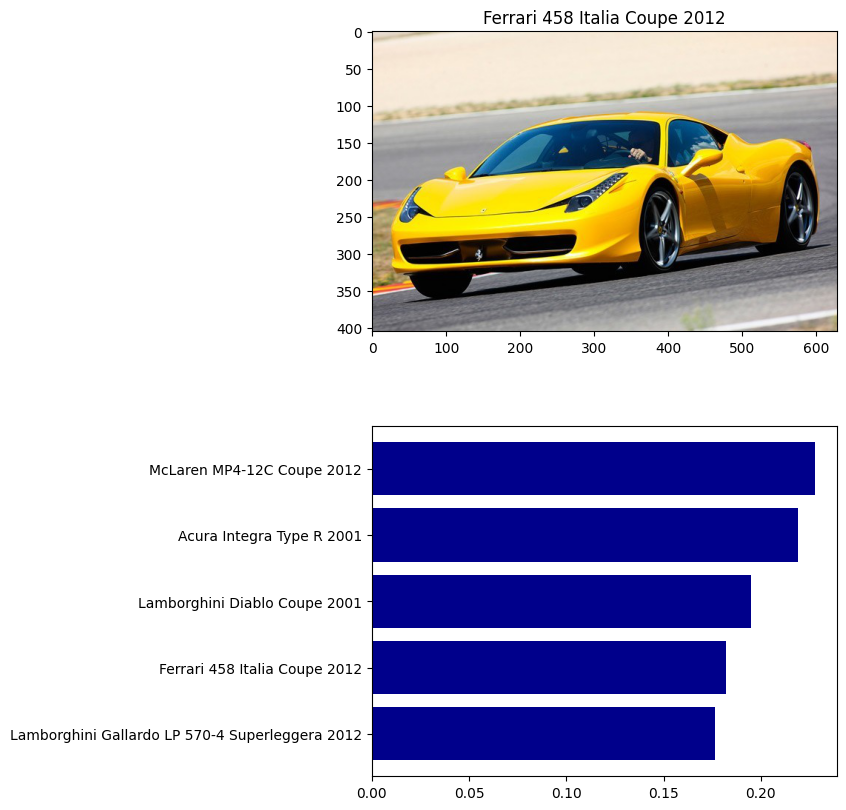

In [ ]:
cardir='/Ferrari 458 Italia Coupe 2012/07358'
plot_solution(cardir , model)

In [ ]:
import torch.nn as nn
import torchvision.models as models

class ResNetForIdentification(nn.Module):
    def __init__(self, num_classes=57):
        super(ResNetForIdentification, self).__init__()
        self.model = models.resnet34(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Create an instance of the modified ResNetForIdentification model
model = ResNetForIdentification()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 77.3MB/s]


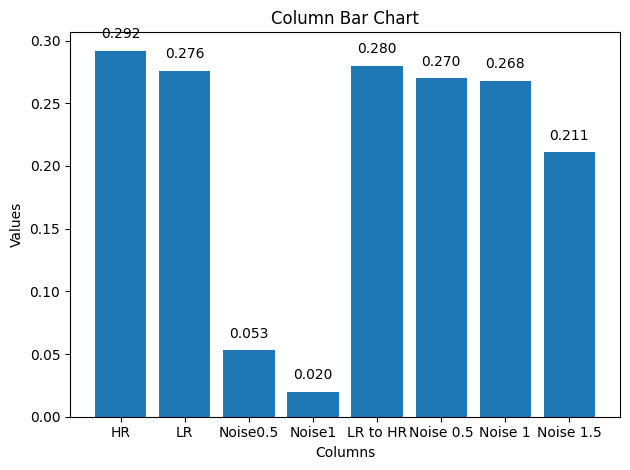

In [ ]:
import matplotlib.pyplot as plt

data = [0.292, 0.276, 0.053, 0.02, 0.28, 0.27, 0.268, 0.211]
column_names = ['HR', 'LR', 'Noise0.5', 'Noise1', 'LR to HR', 'Noise 0.5', 'Noise 1', 'Noise 1.5']

plt.bar(column_names, data)

# Adding values on top of the bars
for i, value in enumerate(data):
    plt.text(i, value + 0.01, f"{value:.3f}", ha='center')

plt.xlabel('Columns')
plt.ylabel('probability')
plt.title('probility average Chart')

plt.tight_layout()
plt.show()

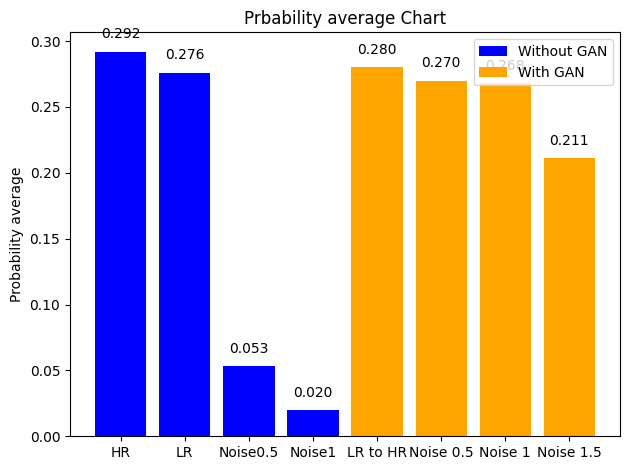

In [ ]:
import matplotlib.pyplot as plt

data = [0.292, 0.276, 0.053, 0.02, 0.28, 0.27, 0.268, 0.211]
column_names = ['HR', 'LR', 'Noise0.5', 'Noise1', 'LR to HR', 'Noise 0.5', 'Noise 1', 'Noise 1.5']

# Splitting the data for two groups
without_gan_data = data[:4]
with_gan_data = data[4:]

without_gan_names = column_names[:4]
with_gan_names = column_names[4:]

plt.bar(without_gan_names, without_gan_data, color='blue', label='Without GAN')
plt.bar(with_gan_names, with_gan_data, color='orange', label='With GAN')

# Adding values on top of the bars
for i, value in enumerate(data):
    plt.text(i, value + 0.01, f"{value:.3f}", ha='center')

#plt.xlabel('Columns')
plt.ylabel('Probability average')
plt.title('Prbability average Chart')
plt.legend()

plt.tight_layout()
plt.show()
